# Comparing node embedding methods on synthetic graphs

# Table of Contents
1. [Overview](#1-overview) 
    1. [Imports](#11-imports)
2. [Disjoint Stochastic Block Model (SBM)](#2-disjoint-stochastic-block-model-sbm-graph)
    1. [Prepare Train and Test Data](#21-prepare-train-and-test-data)
    2. [SVD](#22-svd)
        1. [Evaluation on Link Prediction](#221-evaluation-on-link-prediction)
    3. [NMF](#23-nmf)
        1. [Evaluation on Link Prediction](#231-evaluation-on-link-prediction)
    4. [PyTorch SGD](#24-pytorch--sgd)
        1. [Evaluation on Link Prediction](#241-evaluation-on-link-prediction)
    5. [Putting it all together](#25-putting-it-all-together)
        1. [Takeaways](#251-takeaways)
3. [Overlapping SBMs](#3-overlapping-sbms)
    1. [SVD](#31-svd)
    2. [NMF](#32-nmf)
    3. [PyTorch SGD](#33-pytorch-sgd)
    4. [Putting it all together](#34-putting-it-all-together)
        1. [Takeaways](#341-takeaways)
        
    


# 1: Overview
Learning low-dimensional representations (aka embeddings) for nodes in a graph is a fundamental primitive.  (Ask ChatGPT for some explanation and references if needed.)

**Methods that are being compared:**
Roughly I selected three different approaches from three different eras:
1. SVD: Singular Value Decomposition is the classical approach for solving this problem. (Era: 20th century)
2. NMF: Non-negative matrix factorization is not as old as SVD, but it's still well known and can potentially give interpretable results. (Era: Early 2000s)
3. PyTorch SGD: Here we just learn embeddings using Stochastic Gradient Descent using PyTorch's Adam optimizer, on cross-entropy loss. (Era: 2010s.) The forward pass for (u, v) takes the dot-product of u and v's representations and adds a bias term (shared across all nodes). The optimized loss function is generally Cross Entropy, although I describe a couple of other variations below. 

**Synthetic Graphs:**
I chose the simplest synthetic graph generation technique: the so-called Stochastic Block Model (SBM). The generated graphs are undirected and unweighted, and generally have clear underlying cluster structure. I evaluate on two kinds of SBM: disjoint SBMs (where each node belongs to a single cluster), and overlapping SBMs (where each node has both a primary and a secondary cluster). The latter graphs have a more complicated structure. 

**Tasks:**
The primary task that the methods are being evaluated on is edge prediction on held-out edges. We can also consider "identifying underlying clusters" and/or "removal of 'noisy' edges" as another task that is less quantifiable but still important.  

**Takeaways**
1. SVD and PyTorch SGD generally are more accurate than NMF.  
2. PyTorch SGD seemingly performs better with lower-rank decompositions, compared to SVD. 
3. NMF's embeddings are more interpretable, in the sense that each dimension of the learned embedding typically corresponds cleanly with one of the blocks/clusters in the input graph. 
See [Section 2.5](#25-putting-it-all-together) and [Section 3.4](#34-putting-it-all-together) for more details here. 

## 1.1 Imports

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from scipy import sparse
from sklearn.decomposition import NMF
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torcheval.metrics import BinaryPrecision, BinaryRecall, BinaryNormalizedEntropy, BinaryAUROC, BinaryAccuracy, MeanSquaredError
from collections.abc import Callable
from typing import Union
import pandas as pd


# 2 Disjoint Stochastic Block Model (SBM) graph

Here's some code I wrote for generating SBM graphs. As noted in the comments below, it's geared towards being simple rather than being efficient. In the cells below, I visualize the generated graph which should make it easy to understand what's being generated. 

In [67]:
class SBM:
    """
    A class for generating SBM (stochastic block model) graphs. 
    Each graph consists of equal-sized clusters; the user can specify the size of the graph
    and the number of clusters. 

    This is a simple, rather than optimal, implementation. Not recommended for graphs with more 
    than a thousand or so vertices.  
    """
    def __init__(self, numNodes: int, numClusters: int):
        assert numNodes >= 3 * numClusters, "numVertices needs to be >= 3 * numClusters"
        assert numNodes % numClusters == 0, "numVertices must be a multiple of numClusters"

        self.numNodes = numNodes
        self.numClusters = numClusters
        self._nonSparseResult = None
        self._assignedClusters = None
        self._clusterSize = numNodes / numClusters

    def _getFirstCluster(self, i: int):
        return int(math.floor(i) / self._clusterSize)

    def _getSecondCluster(self, i: int):
        firstCluster = self._getFirstCluster(i)
        secondCluster = firstCluster - 1 if (i % self._clusterSize) <= self._clusterSize / 2 else firstCluster + 1
        if secondCluster < 0:
            secondCluster = self.numClusters - 1 # wrap around the left and go to the right extreme
        if secondCluster == self.numClusters:
            secondCluster = 0 # wrap around the right and go to the left extreme
        assert secondCluster != firstCluster, f"Both clusters are same for node {i}"
        return secondCluster

    """
    Generates a graph with disjoint aka non-overlapping clusters. The probability of an edge
    inside a cluster is given by 'withinClusterProb' parameter; all other edges are sampled
    with probability 'globalProb'.

    The method returns two objects in a tuple. The first is the generated graph, as a 
    dense n x n NumPy array. The second is the assignment of clusters to each node, 
    in an sparse.coo_matrix of shape n x k. This second object is also referred to as 
    the 'original SBM embdding'.  
    """
    def generateDisjointSBM(self, withinClusterProb: float, globalProb: float):
        assert 0 < withinClusterProb < 1, "withinClusterProb must be between 0 and 1"
        assert 0 < globalProb < 1, "globalProb must be between 0 and 1"
        def getLabel(i: int, j: int):
            hashValue = hash(str(min(i, j)) + ":" + str(max(i, j)))
            if self._getFirstCluster(i) == self._getFirstCluster(j):
                return abs(hashValue % 1000) <= withinClusterProb * 1000
            else:
                return abs(hashValue % 1000) <= globalProb * 1000

        self._nonSparseResult = np.array([[int(getLabel(i, j)) for j in range(self.numNodes)] for i in range(self.numNodes)])
        nodeToClusterWts = np.array([math.sqrt(withinClusterProb)] * self.numNodes)
        nodeToClusters = np.array([(i, self._getFirstCluster(i)) for i in range(self.numNodes)])
        self._assignedClusters = sparse.coo_matrix((nodeToClusterWts, (nodeToClusters[:, 0], nodeToClusters[:, 1])))
        return (self._nonSparseResult, self._assignedClusters)

    """
    Generates a graph with overlapping clusters. Each node belongs to two clusters - a primary 
    and a secondary cluster. Probability of an edge (u, v) is highest if u and v share both 
    primary and secondary clusters; second highest if they share only the primary cluster; 
    third highest if they share only the secondary cluster; and the least if they share no cluster. 

    The method returns two objects in a tuple. The first is the generated graph, as a 
    dense n x n NumPy array. The second is the assignment of clusters to each node, 
    in an sparse.coo_matrix of shape n x k. This second object is also referred to as 
    the 'original SBM embdding'.  
    """
    def generateOverlappingSBM(self, probFor1stCluster: float, probFor2ndCluster: float, globalProb: float):
        assert 0 < probFor1stCluster < 1, "probFor1stCluster must be between 0 and 1"
        assert 0 < probFor2ndCluster < 1, "probFor2ndCluster must be between 0 and 1"
        assert 0 < globalProb < 1, "globalProb must be between 0 and 1"

        probForTwoClusters = 1 - (1 - probFor1stCluster) * (1 - probFor2ndCluster) 

        def getProb(i: int, j: int):
            if self._getFirstCluster(i) == self._getFirstCluster(j) and self._getSecondCluster(i) == self._getSecondCluster(j):
                return probForTwoClusters
            elif self._getFirstCluster(i) == self._getFirstCluster(j):
                return probFor1stCluster
            elif self._getSecondCluster(i) == self._getFirstCluster(j) or self._getSecondCluster(j) == self._getFirstCluster(i):
                return probFor2ndCluster
            else:
                return globalProb

        def doesEdgeExist(i: int, j: int):    
            p = getProb(i, j)
            hashValue = hash(str(min(i, j)) + ":" + str(max(i, j)))
            return abs(hashValue % 1000) <= p * 1000

        nodeToClusterWts = np.array([1, 0.5] * self.numNodes)
        nodeToClusterIs = np.array([[i, i] for i in range(self.numNodes)]).flatten()
        nodeToClusterJs = np.array([[self._getFirstCluster(i), self._getSecondCluster(i)] for i in range(self.numNodes)]).flatten()
        self._assignedClusters = sparse.coo_matrix((nodeToClusterWts, (nodeToClusterIs, nodeToClusterJs)))
        
        self._nonSparseResult = np.array([[int(doesEdgeExist(i, j)) for j in range(self.numNodes)] for i in range(self.numNodes)])
        
        return (self._nonSparseResult, self._assignedClusters)


Now let's generate some SBM graphs. Let's start with a simple graph with 200 nodes arranged into 5 clusters (or blocks), and where each node belongs to a single cluster. The probability of an edge between two nodes in the same block is 0.5, and 0.05 otherwise. 

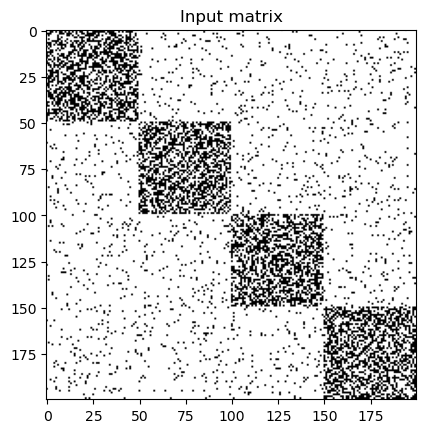

In [3]:
n = 200
numClusters = 4

sbm = SBM(n, numClusters)
(full, sbmEmbs) = sbm.generateDisjointSBM(0.5, 0.05)
plt.imshow(full, cmap="binary")
plt.title("Input matrix")
plt.show()


As can be seen above, the graph has 5 clusters/blocks, which are the nodes 1-40, 41-80, 81-120, 121-160, and 161-200. Most of the edges in the graph are concentrated inisde these clusters, with a random smattering of edges outside. 

We will be making more visualizations of this sort, and it'll be helpful to view all of them together. To make that easy, let us make a dictionary to hold all these matrices that we'll visualize together. 

In [4]:
plotMatrices = {}
plotMatrices["input"] = full



We also have the `sbmEmbs` object which indicates which cluster each node belongs to. We can treat this also as a sparse embedding of the input nodes, and use it as a baseline to compare the other methods against. Using it as a baseline is only for the purposes of understanding; in actual applications, we won't have access to this information. 

In [5]:
sbmEmbsDense = sbmEmbs.todense()
sbmEmbsDense[0, :]

matrix([[0.70710678, 0.        , 0.        , 0.        ]])

We can reconstruct the original matrix from these cluster assignments. The edges outside the clusters that are randomly scattered about are not recovered, while each cluster becomes a perfect clique.  

In [6]:
# Let's put this code in a function so it's easy to reuse
def plotReconstructed(m: torch.Tensor, t: float, name: str):
    sp = torch.where(m >= t, m, 0)
    plt.imshow(sp, cmap="binary")
    plt.title(f"Matrix reconstructed using {name}")
    plt.show()

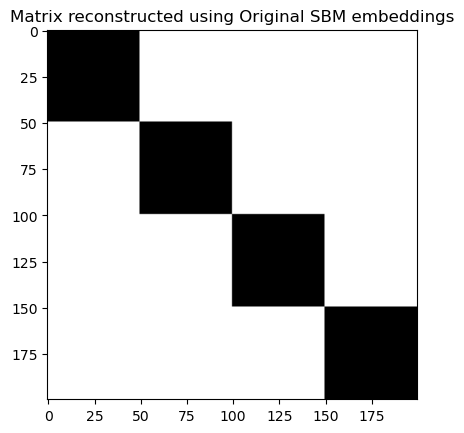

In [7]:
t = torch.tensor(sbmEmbs.todense())
bsmReconstructed = t @ t.transpose(1, 0)
# Use a nominal threshold of 0.01
plotReconstructed(bsmReconstructed, 0.01, "Original SBM embeddings")
plotMatrices["Original SBM embeddings"] = bsmReconstructed


## 2.1 Prepare Train and Test Data

In [8]:
## Create a tensor with (n choose 2) rows and 3 columns. 
## NOTE: Since we're dealing with undirected graphs, it's important to generate (n choose 2) rows 
## and not all n^2 rows, to avoid the same node pair
## being present in both train and test splits, which will result in leakage. 
## First 2 columns indicate the node ids and 3rd column indicates whether an edge is present. 
fullTensor = torch.tensor([(i, j, full[i, j]) for i in range(n) for j in range(i+1, n)])
fullX = fullTensor[:, 0:2]
fullY = fullTensor[:, 2]
fullData = TensorDataset(fullX, fullY)
## 95% train, 5% test
trainSplit, testSplit = torch.utils.data.random_split(fullData, [0.95, 0.05])


In [9]:
## For SVD and NMF, we need to prepare a sparse.coo_matrix as input. 
## We will now represent an edge in both directions and prepare a symmetric matrix. 
trainColsHalf = np.array([[x[0][0].item(), x[0][1].item(), y.item()] for x, y in DataLoader(trainSplit)])
trainColsOtherHalf = np.column_stack((trainColsHalf[:, 1], trainColsHalf[:, 0], trainColsHalf[:, 2]))
trainCols = np.concatenate((trainColsHalf, trainColsOtherHalf))
spTrain = sparse.coo_matrix((trainCols[:, 2], (trainCols[:, 0], trainCols[:, 1]))).astype(float)


## 2.2 SVD

We will run SVD using the `scipy.sparse.linalg` package's implementation, which is optimized for sparse matrices, and for fetching only the top k singular vectors (instead of the full decomposition). 

We will start by running SVD for as many dimensions as there exist blocks/clusters in the graph. Later we will see what happens if we use fewer. 

In [10]:
k = numClusters
uOrig, s, vOrig = sparse.linalg.svds(spTrain, k)
u = torch.tensor(uOrig @ np.sqrt(sparse.diags(s)))
v = torch.tensor(np.sqrt(sparse.diags(s)) @ vOrig)
# Verify that u and v are transposes of one another. 
assert torch.norm(u - v.transpose(1, 0), 1) < 1e-5
# From here on, we can just operate with u. 
u.shape


torch.Size([200, 4])

Before we test the quality of the SVD formally, we can reconstruct the input matrix using the SVD's learned representation, and inspect it visually. 

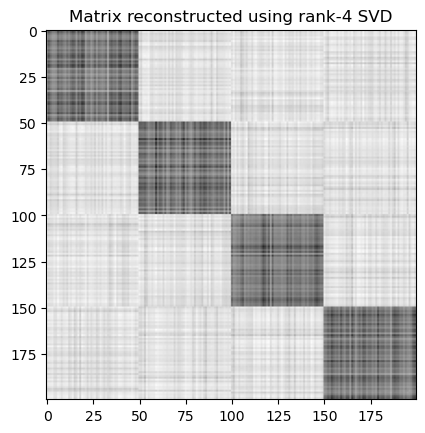

In [11]:
svd_reconstructed = u @ u.transpose(1, 0)
plt.imshow(svd_reconstructed, cmap='binary')
plt.title("Matrix reconstructed using rank-4 SVD")
plt.show()



The reconstructed matrix looks pretty good. Let's see if there's a clear separation in the values of this reconstructed matrix. 

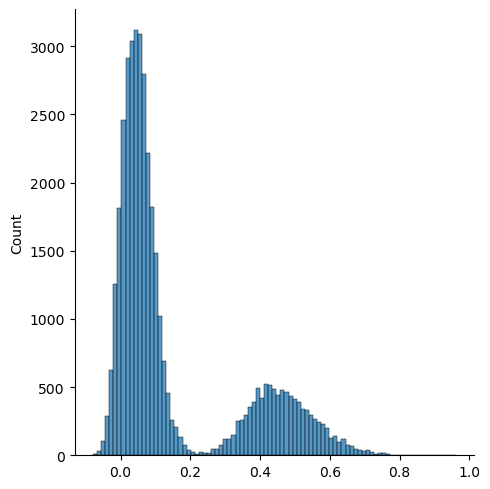

In [12]:
import seaborn as sns
sns.displot(svd_reconstructed.view(n * n))


Looking at the above distribution, it looks like we can roughly use 0.2 as a cutoff. Only scores above 0.2 are considered to be predictions of an edge. Let us replot the reconstructed matrix using 0.2 as the threshold.

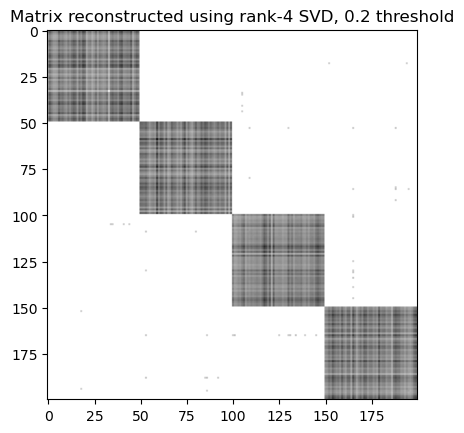

In [13]:
plotReconstructed(svd_reconstructed, 0.2, "rank-4 SVD, 0.2 threshold")
plotMatrices["rank-4 SVD, threshold=0.2"] = torch.where(svd_reconstructed >= 0.2, svd_reconstructed, 0)

Nice! That got rid of most of the entries outside the four blocks. 

Now, let's inspect the singular vectors and values themselves. 

In [14]:
s

array([21.12315604, 21.7613485 , 21.94558578, 31.22483268])

The singular values are all close to one another, indicating that the 4 vectors are of roughly similar importance. 

To inspect the singular vectors, let's put them in a Pandas DataFrame for easy visualization. 

In [15]:
labels = pd.DataFrame(
    [(i, f"cluster-{int(math.floor(i/(n/numClusters)))}") for i in range(n)], 
    columns=["node id", "label"]
)

u_no_labels = pd.DataFrame(
    [(i, j, u[i, j].item()) for i in range(u.shape[0]) for j in range(u.shape[1])], 
    columns=["node id", "dimension", "singular value"]
)

u_df = pd.merge(u_no_labels, labels, on="node id")


In [16]:
u_df

node id  dimension  singular value      label
0          0          0       -0.117971  cluster-0
1          0          1        0.378479  cluster-0
2          0          2        0.306548  cluster-0
3          0          3        0.309092  cluster-0
4          1          0       -0.066635  cluster-0
..       ...        ...             ...        ...
795      198          3        0.379236  cluster-3
796      199          0       -0.164781  cluster-3
797      199          1       -0.624238  cluster-3
798      199          2        0.297157  cluster-3
799      199          3        0.462232  cluster-3

[800 rows x 4 columns]

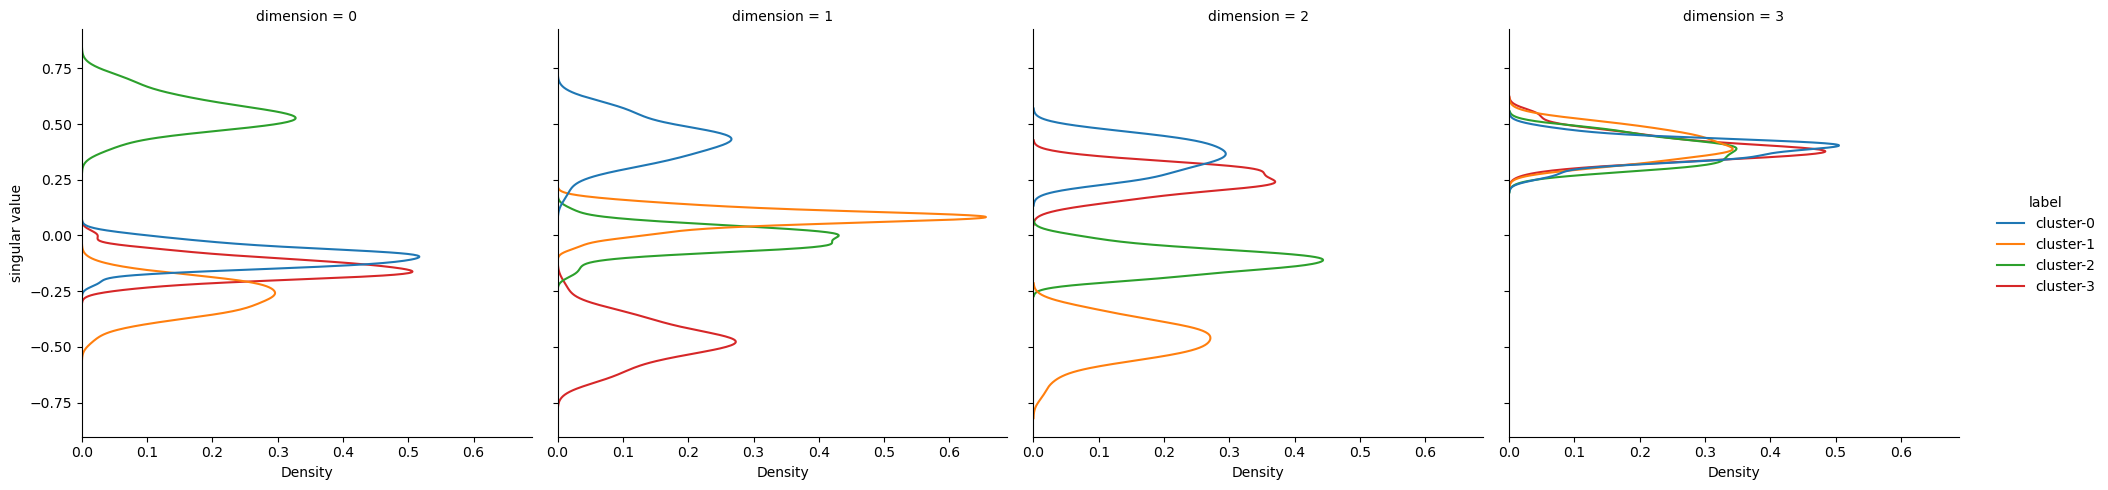

In [17]:
import seaborn as sns
sns.displot(data=u_df, y="singular value", hue="label", kind="kde", col="dimension")


Looking at the above plots, it's clear that dimensions 0, 1, and 2 are putting the different clusters in different locations, while dimension 3 mostly just groups them all together. Dimension 3 also is the one with the highest singular value (~31), while the others have singular values around ~22. I suspect Dimension 3 is mostly for modeling the "background noise" in the graph. 

Given this, can we just ignore the top eigenvector, since we don't particularly care about modeling the noise? 

Before we do that, let us run SVD with higher dimensionality and look at the series of singular values to check if there's any more "important" dimensions past the top 4. 

In [18]:
u10, s10, v10 = sparse.linalg.svds(spTrain, 10)
s10

array([ 8.06950667,  8.25533259,  8.38545345,  8.41279599,  8.79846492,
        9.09562103, 21.12315604, 21.7613485 , 21.94558578, 31.22483268])

Ok, so we see a gap between the first 6 and the last 4 singular values, suggesting that most of the information is contained in those last 4 dimensions. 

Let us now get rank-3 and rank-2 SVD by discarding the eigenvector which we just observed doesn't carry much information. 

In [19]:
u3 = u[:, 0:3]
u2 = u[:, 1:3]

svd3_reconstructed = u3 @ u3.transpose(1, 0)
svd2_reconstructed = u2 @ u2.transpose(1, 0)

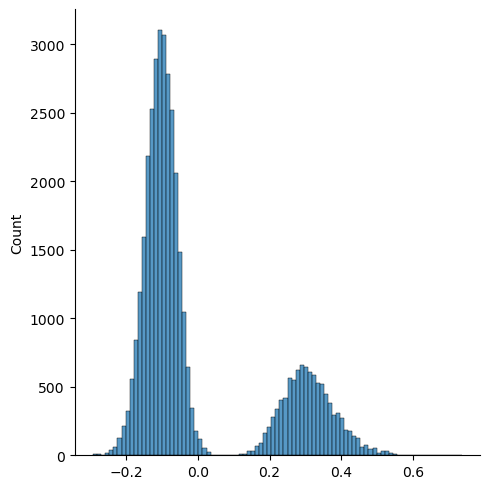

In [20]:
sns.displot(svd3_reconstructed.view(n*n))

Looks like 0.05 would be a good threshold for Rank-3 SVD.

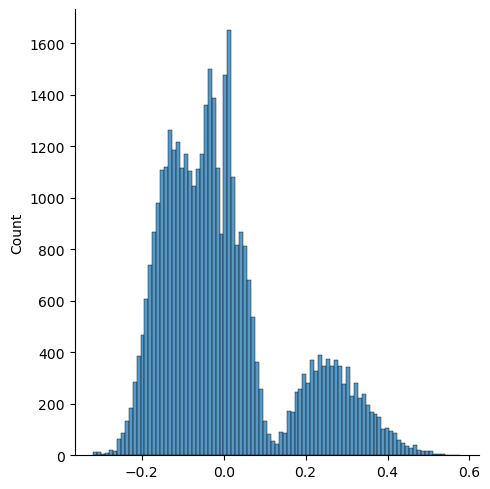

In [21]:
sns.displot(svd2_reconstructed.view(n*n))

Looks like 0.1 might be a good threshold for Rank-2 SVD. 

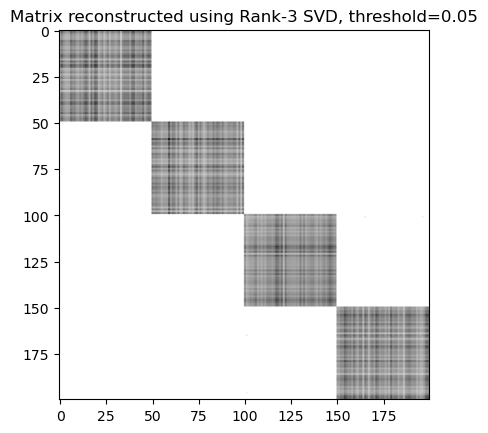

In [22]:
plotReconstructed(svd3_reconstructed, 0.05, "Rank-3 SVD, threshold=0.05")
plotMatrices["rank-3 SVD, threshold=0.05"] = torch.where(svd3_reconstructed >= 0.05, svd3_reconstructed, 0)

That looks pretty good, very comparable to Rank-4 SVD. 

Let us visualize the reconstruction from Rank-2 SVD as well. 

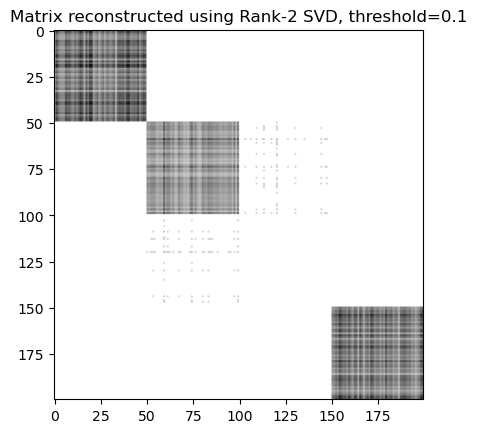

In [57]:
plotReconstructed(svd2_reconstructed, 0.1, "Rank-2 SVD, threshold=0.1")
plotMatrices["rank-2 SVD, threshold=0.1"] = torch.where(svd2_reconstructed >= 0.1, svd2_reconstructed, 0)

This doesn't look as clean as the previous results. Definitely there's a degradation in going from Rank-3 to Rank-2. 

### 2.2.1 Evaluation on Link Prediction

Let us now see how quantify the performance of the SVD embeddings on predicting edges in the held-out set. (Remember that SVD was run on the 95% training split). Before we get to evaluation, here's a helper function to run the eval. 

In [24]:
from torcheval.metrics import BinaryPrecision, BinaryRecall, BinaryNormalizedEntropy, BinaryAUROC, BinaryAccuracy, MeanSquaredError

def evaluate(predFn: Callable[[torch.Tensor], torch.Tensor], data: TensorDataset, threshold=0.2, posClassWeight=1):
    """
    Evaluate predFn on data. predFn takes as input a n x 2 Tensor and returns an n x 1 Tensor with the predicted 
    scores in the (0, 1) range. 
    """
    loader = DataLoader(data, batch_size=1000)
    prec = BinaryPrecision(threshold=threshold)
    rec = BinaryRecall(threshold=threshold)
    bne = BinaryNormalizedEntropy()
    acc = BinaryAccuracy()
    auroc = BinaryAUROC()
    mse = MeanSquaredError()
    for x, y in loader:
        pred = predFn(x).float()
        prec.update(pred, y)
        rec.update(pred, y)
        acc.update(pred, y)
        mse.update(pred, y)
        classWeights = torch.where(y > 0, posClassWeight, 1)    
        bne.update(pred, y.float(), weight = classWeights)
        auroc.update(pred, y)
    return {
        "Mean. Squared Error": mse.compute().item(),
        "Accuracy": acc.compute().item(),
        "Precision": prec.compute().item(),
        "Recall": rec.compute().item(),
        "AUROC": auroc.compute().item(),        
        "CrossEntropy": bne.compute().item(),
    }    


In [25]:
# Prediction function for SVD
def predFnSVD(x: torch.Tensor):
    # Dot product between first node's vector and second node's vector. 
    og = torch.sum(torch.mul(u[x[:, 0]], u[x[:, 1]]), dim=1)
    # Truncate the result to the [0, 1] range. 
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

# We determined previously that 0.2 is a good threshold
evaluate(predFnSVD, testSplit, threshold=0.2)

{'Mean. Squared Error': 0.10492630302906036,
 'Accuracy': 0.8251256346702576,
 'Precision': 0.5340909361839294,
 'Recall': 0.8057143092155457,
 'AUROC': 0.806425087108014,
 'CrossEntropy': 2.8229927343857906}

Cool, so we have some results. Let's move on to the other methods and generate results for them too, so we can compare them all. 

Let us make a dictionary to hold these results in, so we can keep adding results in for different methods and at the end we can view them side-by-side. 

In [26]:
resultsDict = {}
resultsDict["rank-4 SVD"] = evaluate(predFnSVD, testSplit, threshold=0.2)

In [27]:
def predFnSVD3(x: torch.Tensor):
    # Dot product between first node's vector and second node's vector. 
    og = torch.sum(torch.mul(u3[x[:, 0]], u3[x[:, 1]]), dim=1)
    # Truncate the result to the [0, 1] range. 
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

r = evaluate(predFnSVD3, testSplit, threshold=0.05)
resultsDict["rank-3 SVD"] = r
r

{'Mean. Squared Error': 0.11589575558900833,
 'Accuracy': 0.8231155872344971,
 'Precision': 0.5340909361839294,
 'Recall': 0.8057143092155457,
 'AUROC': 0.827993031358885,
 'CrossEntropy': 7.816683964620758}

There's a marked degradation in CrossEntropy, but the other metrics are very similar between Rank-4 and Rank-3 SVD. CrossEntropy generally degrades the further one moves away from calibrated probabilities. 

Let's see the results for Rank-2 SVD. 

In [63]:
def predFnSVD2(x: torch.Tensor):
    # Dot product between first node's vector and second node's vector. 
    og = torch.sum(torch.mul(u2[x[:, 0]], u2[x[:, 1]]), dim=1)
    # Truncate the result to the [0, 1] range. 
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

r = evaluate(predFnSVD2, testSplit, threshold=0.1)
resultsDict["rank-2 SVD"] = r
r

{'Mean. Squared Error': 0.13715985417366028,
 'Accuracy': 0.8241205811500549,
 'Precision': 0.5026177763938904,
 'Recall': 0.5485714077949524,
 'AUROC': 0.7824947735191637,
 'CrossEntropy': 7.727273555680658}

## 2.3 NMF

Let's use SciKitLearn's NMF implementation. 


In [29]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=k, max_iter=1000)
nmf_w = nmf.fit_transform(spTrain)
nmf_w = torch.tensor(nmf_w)


In [30]:
nmf_w[0, :]

tensor([0.1290, 0.0321, 0.0196, 0.0000], dtype=torch.float64)

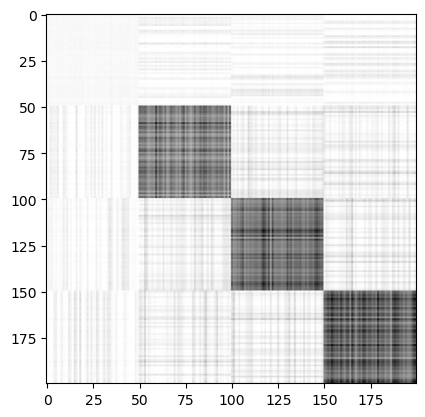

In [31]:
nmf_reconstructed = nmf_w @ nmf_w.T
plt.imshow(nmf_reconstructed, cmap="binary")
plt.show()

Let's see what the distribution of values in the reconstructed matrix is. 

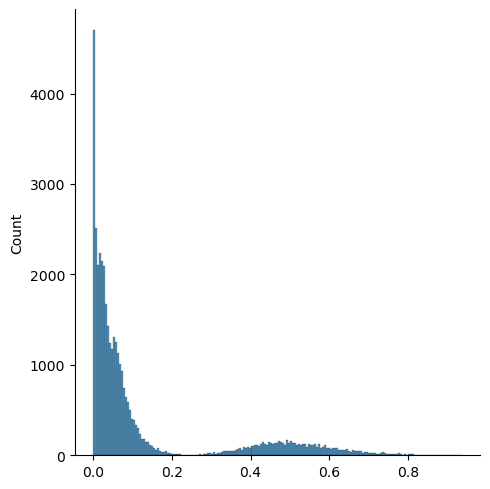

In [32]:
sns.displot(nmf_reconstructed.view(n*n))

Looks like there's two groups, which are naturally separated at ~0.15, so let's use that as a threshold and replot the reconstructed matrix. 

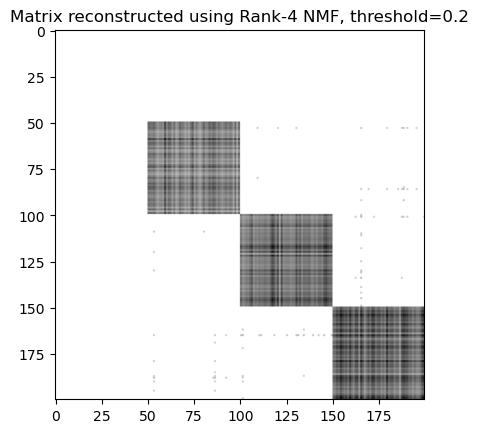

In [58]:
plotReconstructed(nmf_reconstructed, 0.2, "Rank-4 NMF, threshold=0.2")
plotMatrices["rank-4 NMF, threshold=0.2"] = torch.where(nmf_reconstructed > 0.2, nmf_reconstructed, 0)

So, for some reason one block is entirely not modeled by NMF. Let's see if increasing the rank from 4 to 5 fixes that. 

In [34]:
_nmf5 = NMF(n_components=k+1, max_iter=1000)
nmf5 = _nmf5.fit_transform(spTrain)
nmf5 = torch.tensor(nmf5)


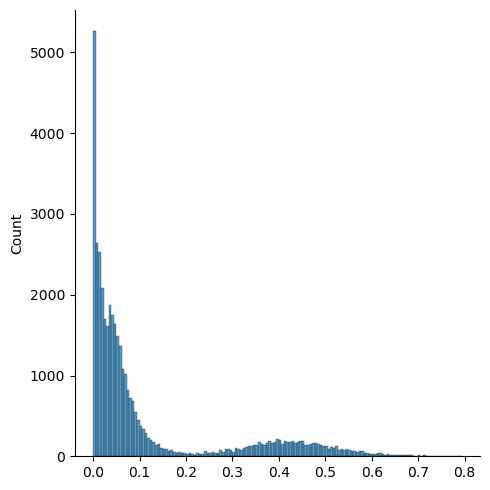

In [35]:
nmf5_reconstructed = nmf5 @ nmf5.T
sns.displot(nmf5_reconstructed.view(n*n))

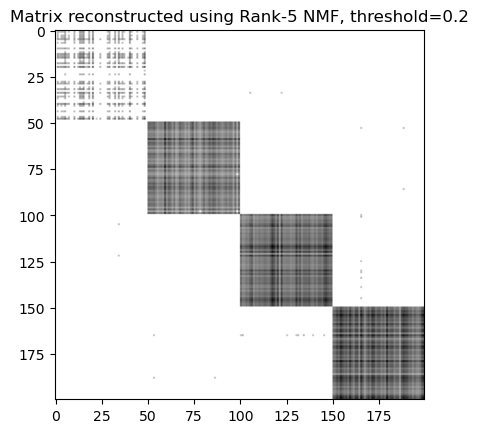

In [59]:
plotReconstructed(nmf5_reconstructed, 0.2, "Rank-5 NMF, threshold=0.2")
plotMatrices["rank-5 NMF, threshold=0.2"] = torch.where(nmf5_reconstructed > 0.2, nmf5_reconstructed, 0)

Now we're able to recover all 4 clusters, although qualitatively the result still looks worse than what we got with SVD. 

Let's inspect the dimensions as we did with SVD to see what we can find. 

In [37]:
labels = pd.DataFrame(
    [(i, f"cluster-{int(math.floor(i/(n/numClusters)))}") for i in range(n)], 
    columns=["node id", "label"]
)

nmf_no_labels = pd.DataFrame(
    [(i, j, nmf5[i, j].item()) for i in range(nmf5.shape[0]) for j in range(nmf5.shape[1])], 
    columns=["node id", "dimension", "nmf value"]
)

nmf_df = pd.merge(nmf_no_labels, labels, on="node id")


In [38]:
nmf_df

node id  dimension  nmf value      label
0          0          0   0.074428  cluster-0
1          0          1   0.014905  cluster-0
2          0          2   0.008584  cluster-0
3          0          3   0.000000  cluster-0
4          0          4   0.197860  cluster-0
..       ...        ...        ...        ...
995      199          0   0.000000  cluster-3
996      199          1   0.018866  cluster-3
997      199          2   0.854780  cluster-3
998      199          3   0.040215  cluster-3
999      199          4   0.054105  cluster-3

[1000 rows x 4 columns]

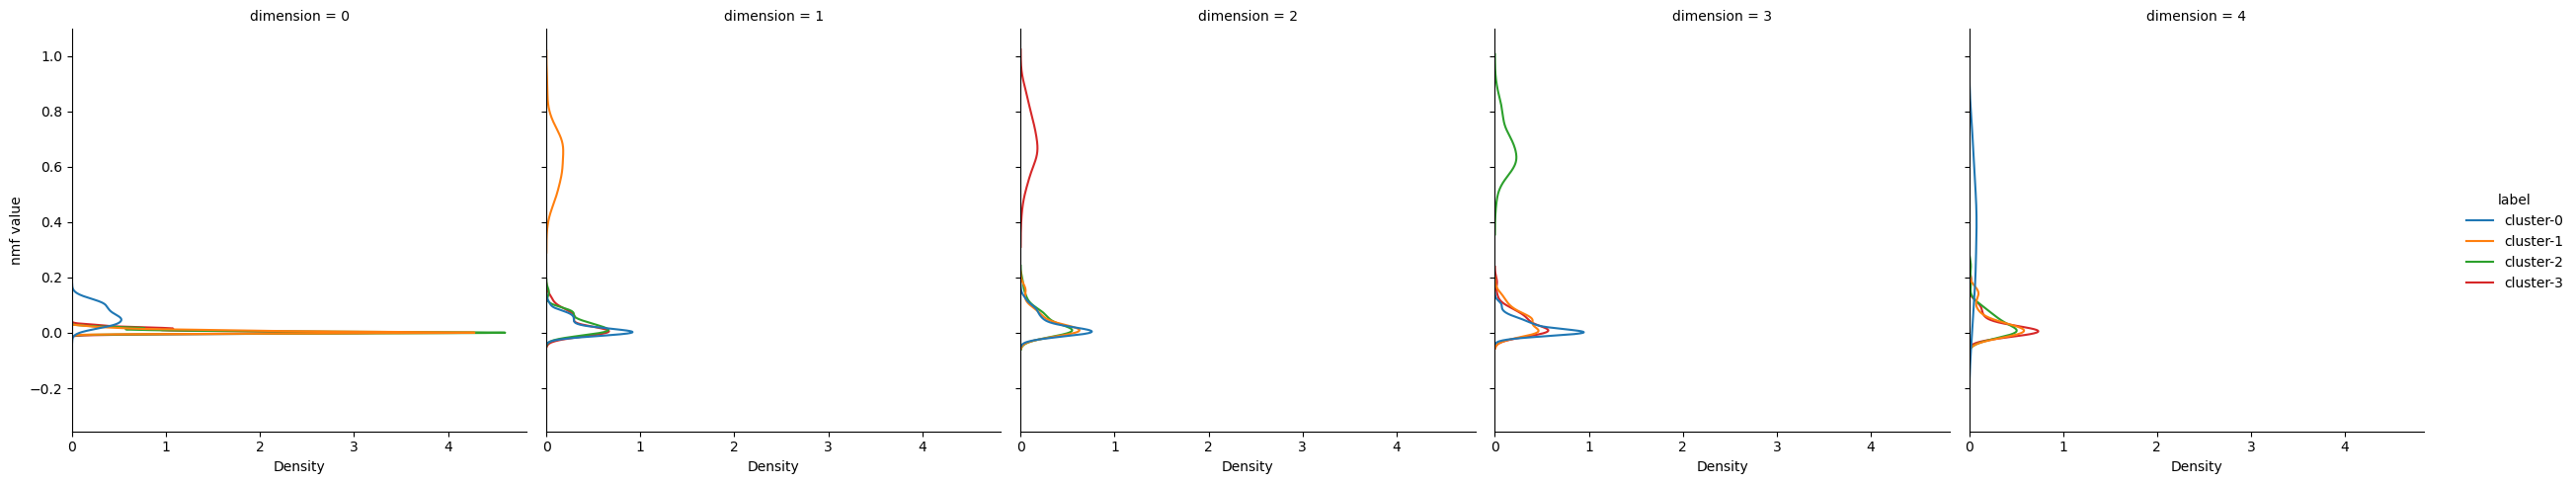

In [39]:
sns.displot(data=nmf_df, y="nmf value", hue="label", kind="kde", col="dimension")

It looks like each cluster gets its own dimension, pretty much. E.g. for dimension 0, only nodes belonging to one of the clusters have non-zero values while the other 3 clusters mostly have a value of 0. The embeddings here definitely seem more interpretable and "cleaner" for a human to understand. 


### 2.3.1 Evaluation on Link Prediction

Let us run the same evaluation we did for SVD, and see how it compares. As before, we need to define a prediction function. 

In [60]:
def predFnNMF(x: torch.Tensor):
    og = torch.sum(torch.mul(nmf_w[x[:, 0]], nmf_w[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

r=evaluate(predFnNMF, testSplit, threshold=0.2)
resultsDict["rank-4 NMF"] = r
r


{'Mean. Squared Error': 0.12357822060585022,
 'Accuracy': 0.8261306285858154,
 'Precision': 0.5179487466812134,
 'Recall': 0.5771428346633911,
 'AUROC': 0.7115679442508711,
 'CrossEntropy': 0.9776723544278366}

Let's also evaluate the rank-5 NMF results. 

In [61]:
def predFnNMF5(x: torch.Tensor):
    og = torch.sum(torch.mul(nmf5[x[:, 0]], nmf5[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

r=evaluate(predFnNMF5, testSplit, threshold=0.2)
resultsDict["rank-5 NMF"] = r
r

{'Mean. Squared Error': 0.11834811419248581,
 'Accuracy': 0.8231155872344971,
 'Precision': 0.521327018737793,
 'Recall': 0.6285714507102966,
 'AUROC': 0.7588188153310105,
 'CrossEntropy': 1.1398319600440663}

Let's move on to PyTorch + SGD. 


## 2.4 PyTorch + SGD

The loss function we will optimize here is CrossEntropy. The prediction function aka the forward pass is simple; given parameters $b$ (scalar) and $emb$ (matrix of rank $n \times k$), $f(i, j) = b + dot(emb[i], emb[j])$. The output of this prediction function is treated as a logit, so if you want a probability, you'll need to apply the sigmoid to that. 

The code below also optionally adds L1 and L2 penalties to the CrossEntropy loss. I found that these parameters were hard to tune, so in the end I am setting these to zero. My main motivation for adding these penalities, L1 penalty especially, was to see if one could learn sparse, interpretable embeddings this way, but I was not able to make this happen. I also tried using other loss functions such as hinge loss and MSE, but learning sparse, interpretable embeddings proved elusive. 

Avg L1 norm at init time:0.8077005767822265
Training epoch non-zero fraction  0.259
non-zero fraction  0.287
non-zero fraction  0.331
non-zero fraction  0.374
non-zero fraction  0.453
non-zero fraction  0.539
non-zero fraction  0.581
non-zero fraction  0.612
non-zero fraction  0.642
non-zero fraction  0.677
non-zero fraction  0.703
non-zero fraction  0.736
non-zero fraction  0.769
non-zero fraction  0.799
non-zero fraction  0.826
non-zero fraction  0.846
non-zero fraction  0.868
non-zero fraction  0.884
non-zero fraction  0.909
non-zero fraction  0.919
non-zero fraction  0.932
non-zero fraction  0.939
non-zero fraction  0.947
non-zero fraction  0.950
non-zero fraction  0.956
non-zero fraction  0.957
non-zero fraction  0.959
non-zero fraction  0.964
non-zero fraction  0.968
non-zero fraction  0.973
non-zero fraction  0.984
non-zero fraction  0.986
non-zero fraction  0.991
non-zero fraction  0.993
non-zero fraction  0.993
non-zero fraction  0.996
non-zero fraction  0.996
non-zero fractio

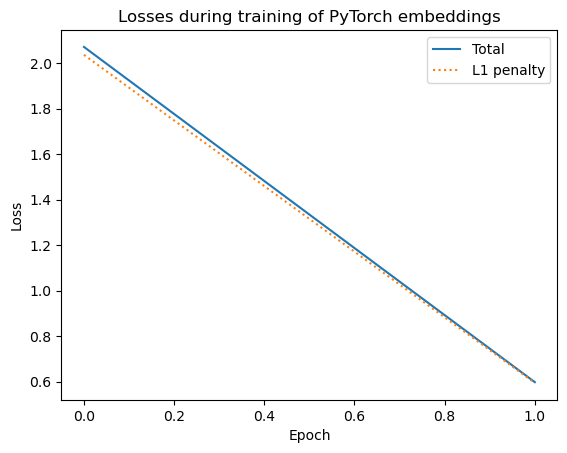

In [138]:
class GraphEmbeddingPyTorch(nn.Module):
    def __init__(self, n: int, k: int, rseed: int):
        super().__init__()
        g = torch.Generator().manual_seed(rseed)
        self.n = n
        self.k = k
        #self.embs = torch.randn((n, k), generator = g, requires_grad=True) 
        self.embs = torch.empty(n, k, requires_grad=True) #, generator = g, requires_grad=True)
        nn.init.sparse_(self.embs, sparsity=0.75, std=1)
        self.b = torch.tensor([0.], requires_grad=True) #torch.randn(1, generator = g, requires_grad=True)
        self.params = [self.embs, self.b]

    def forward(self, x):
        assert x.shape[1] == 2, f"input needs to have 2 columns, received shape is {x.shape}"
        return self.b + torch.sum(torch.mul(self.embs[x[:, 0]], self.embs[x[:, 1]]), dim=1)

def hingeLoss(preds, actuals, threshold, posClassWeight=1):
    preds -= threshold
    actuals = torch.where(actuals <= 0, -1, actuals)
    signs = -actuals * preds
    loss = torch.where(signs > 0, signs, 0)
    weightedLoss = torch.where(actuals > 0, posClassWeight * loss, loss)
    return torch.mean(weightedLoss)

def train(
    data: TensorDataset, 
    n: int, 
    k: int, 
    rseed: int=50, 
    nepochs: int = 10, 
    batchSize: int = 100, 
    l2: float = 0.0, 
    l1: float = 0.0,             
    posClassWeight: float = 1.0
):
    emb = GraphEmbeddingPyTorch(n, k, rseed)
    print(f"Avg L1 norm at init time:{torch.norm(emb.embs, 1).item() / n}")
    optim = torch.optim.Adam(emb.params)

    loader = DataLoader(data, batch_size = batchSize, shuffle = True)
    lossesTraining = [0] * nepochs
    l1Penalties = [0] * nepochs
    l2Penalties = [0] * nepochs
    print("Training epoch ", end="")
    epoch = 0
    while epoch < nepochs:
        numBatchesInEpoch = 0
        
        for x_batch, y_batch in loader:
            preds = emb.forward(x_batch)
            actuals = y_batch.float()
            #classWeights = torch.where(actuals > 0, posClassWeight, 1)
            #loss = F.binary_cross_entropy_with_logits(preds, actuals, classWeights)
            loss = hingeLoss(preds, actuals, threshold=0, posClassWeight=posClassWeight)
            if l1 > 0:
                l1Penalty = l1 * torch.norm(emb.embs, 1) 
                loss += l1Penalty
                l1Penalties[epoch] += l1Penalty.item()
            if l2 > 0:
                l2Penalty = l2 * torch.norm(emb.embs, 2) 
                loss += l2Penalty
                l2Penalties[epoch] += l2Penalty.item()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            print(f"non-zero fraction {torch.count_nonzero(emb.embs).item() / torch.numel(emb.embs): .3f}")

            lossesTraining[epoch] += loss.item()
            numBatchesInEpoch += 1
        lossesTraining[epoch] /= numBatchesInEpoch
        l1Penalties[epoch] /= numBatchesInEpoch
        l2Penalties[epoch] /= numBatchesInEpoch        

        if epoch % 1 == 0:
            print(f"Epoch {epoch}: Loss {lossesTraining[epoch]: .3f}, l1Penalty {l1Penalties[epoch]: .3f}, " +
            f"non-zero fraction {torch.count_nonzero(emb.embs).item() / torch.numel(emb.embs): .3f}")

        if epoch > 20:
            rollingAvg1 = torch.mean(torch.tensor(lossesTraining[epoch-20:epoch-10])).item()
            rollingAvg2 = torch.mean(torch.tensor(lossesTraining[epoch-10:epoch])).item()
            if abs(rollingAvg1 - rollingAvg2)*100/rollingAvg1 < 0.01:
                print()
                print(f"Ending because loss is asymptoting (rollingAvg1: {rollingAvg1}, rollingAvg2: {rollingAvg2})")
                break
        epoch += 1

    print()
    return emb, lossesTraining[0:epoch], l1Penalties[0:epoch], l2Penalties[0:epoch]

sgd, trainingLosses, l1losses, l2losses = train(trainSplit, n, k, nepochs=2, posClassWeight=1, l1=0.01)
plt.plot(trainingLosses, "-", l1losses, ":")
plt.legend(("Total", "L1 penalty"))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses during training of PyTorch embeddings")
plt.show()


The training takes ~150 epochs for this dataset, and in terms of wall-clock time this is ~10 seconds on my M1 laptop. I did not spend any time trying to optimize this code - afaict, the PyTorch code I have is not doing any under-the-hood parallelization. A real implementation would probably try to leverage GPUs or at least multiple cores on the CPU.

Ok, so let's go through the same sequence of steps we took with the other approaches. First, let's see the distribution of values in the reconstructed matrix. 

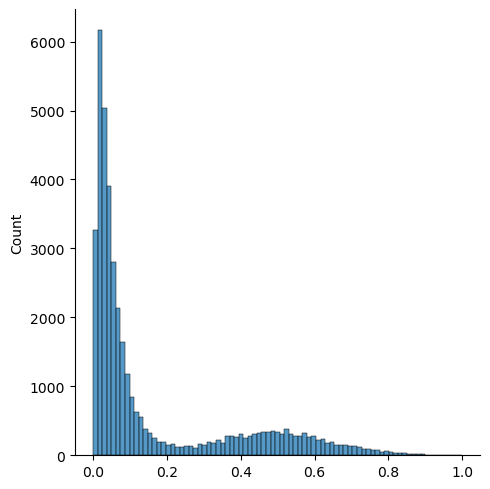

In [43]:
with torch.no_grad():
    sgd_reconstructed = torch.sigmoid(sgd.b + torch.matmul(sgd.embs, torch.t(sgd.embs)))
sns.displot(sgd_reconstructed.view(n*n))


Looks like 0.2 should be a good dividing point between the two groups of predicted values, again. 

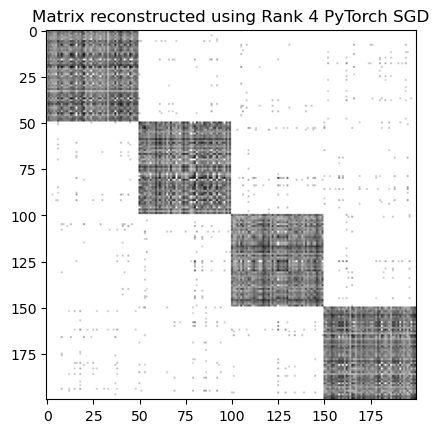

In [44]:
plotReconstructed(sgd_reconstructed, 0.2, "Rank 4 PyTorch SGD")
plotMatrices["rank-4 PyTorch SGD, threshold=0.2"] = torch.where(sgd_reconstructed >= 0.2, sgd_reconstructed, 0)

This looks pretty neat, and qualitatively looks perhaps better than NMF, and comparable to SVD. 

Let's visualize the learned embeddings themselves, and for that let's put the data into a Pandas DF. 

In [45]:
labels = pd.DataFrame(
    [(i, f"cluster-{int(math.floor(i/(n/numClusters)))}") for i in range(n)], 
    columns=["node id", "label"]
)

sgd_no_labels = pd.DataFrame(
    [(i, j, sgd.embs[i, j].item()) for i in range(sgd.embs.shape[0]) for j in range(sgd.embs.shape[1])], 
    columns=["node id", "dimension", "SGD emb. value"]
)

sgd_df = pd.merge(sgd_no_labels, labels, on="node id")


In [46]:
sgd_df

node id  dimension  SGD emb. value      label
0          0          0       -0.988454  cluster-0
1          0          1        0.948778  cluster-0
2          0          2        0.348047  cluster-0
3          0          3       -0.263395  cluster-0
4          1          0       -0.907781  cluster-0
..       ...        ...             ...        ...
795      198          3       -1.065125  cluster-3
796      199          0        0.977552  cluster-3
797      199          1       -0.815554  cluster-3
798      199          2        1.565421  cluster-3
799      199          3       -0.419137  cluster-3

[800 rows x 4 columns]

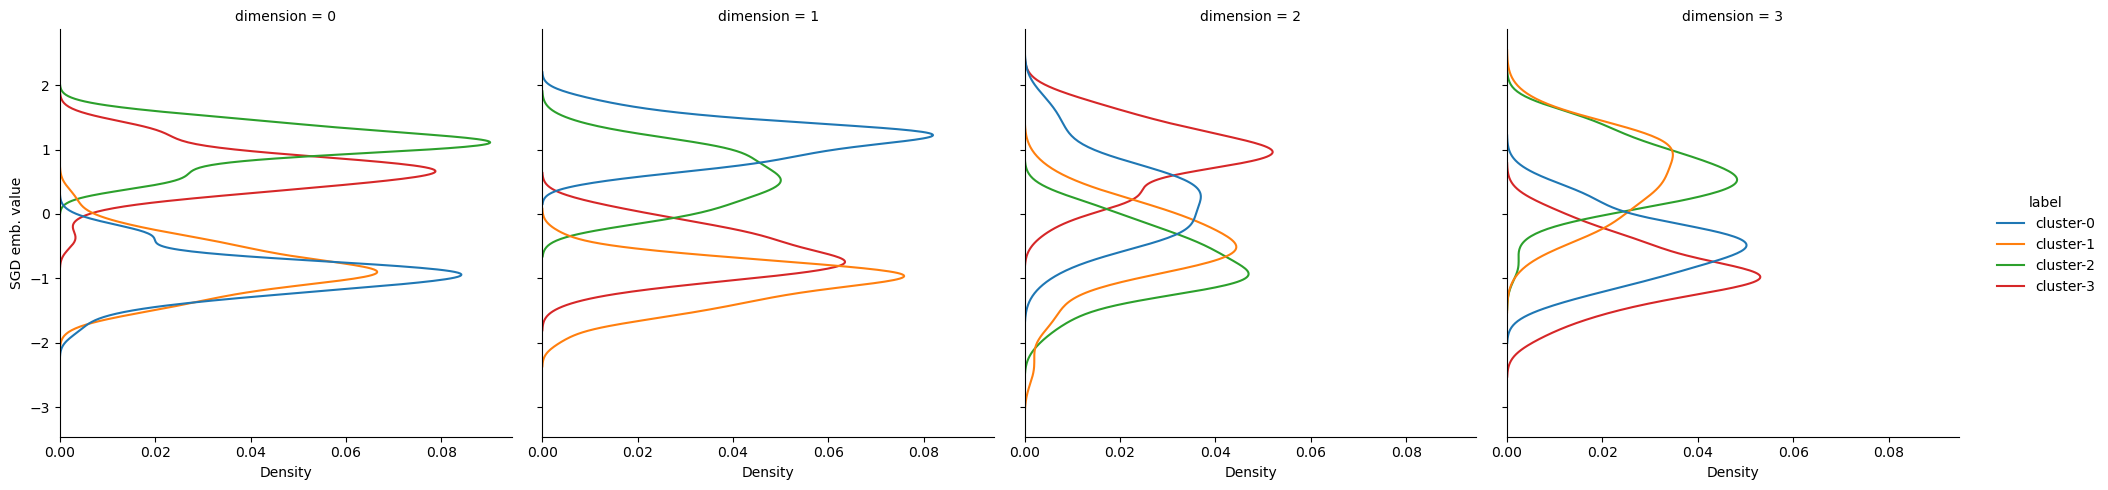

In [47]:
sns.displot(data=sgd_df, y="SGD emb. value", hue="label", kind="kde", col="dimension")

It seems that the clusters do overlap in each dimension, but at the same time there does seem to be some separation. The dimensions are definitely not as easily interpretable as NMF. 

### 2.4.1 Evaluation on Link prediction
Let us now quantify the link prediction performance.  

In [48]:
def predFnSGD(x: torch.Tensor):
    return torch.sigmoid(sgd.forward(x))

with torch.no_grad():
    r = evaluate(predFnSGD, testSplit, threshold=0.2)
resultsDict["rank-4 PyTorch SGD"] = r
r

{'Mean. Squared Error': 0.1081441193819046,
 'Accuracy': 0.8331658244132996,
 'Precision': 0.505415141582489,
 'Recall': 0.800000011920929,
 'AUROC': 0.8010801393728223,
 'CrossEntropy': 0.8022971148381689}

Like we did with SVD, let's also evaluate rank-3 and rank-2 embeddings. 

In [49]:
sgd3, _, _, _ = train(trainSplit, n, 3, nepochs=1000, posClassWeight=1)

Avg L1 norm at init time:2.247059020996094
Training epoch ..0....20....40....60....80....100....120..
Ending because loss is asymptoting (rollingAvg1: 0.0031042308546602726, rollingAvg2: 0.0031044920906424522)



In [50]:
sgd2, _, _, _ = train(trainSplit, n, 2, nepochs=1000, posClassWeight=1)

Avg L1 norm at init time:1.5638401794433594
Training epoch ..0....20....40....60....80....100....120....140....160..
Ending because loss is asymptoting (rollingAvg1: 0.003326084464788437, rollingAvg2: 0.003326407400891185)



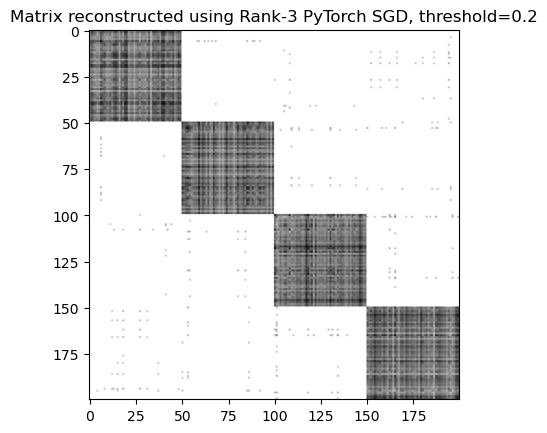

In [51]:
with torch.no_grad():
    sgd3_reconstructed = torch.sigmoid(sgd3.b + torch.matmul(sgd3.embs, torch.t(sgd3.embs)))
plotMatrices["rank-3 PyTorch SGD, threshold=0.2"] = torch.where(sgd3_reconstructed >= 0.2, sgd3_reconstructed, 0)
#sns.displot(sgd3_reconstructed.view(n*n))
plotReconstructed(sgd3_reconstructed, 0.2, "Rank-3 PyTorch SGD, threshold=0.2")

This looks good, and qualitatively no worse than the Rank 4 version. 

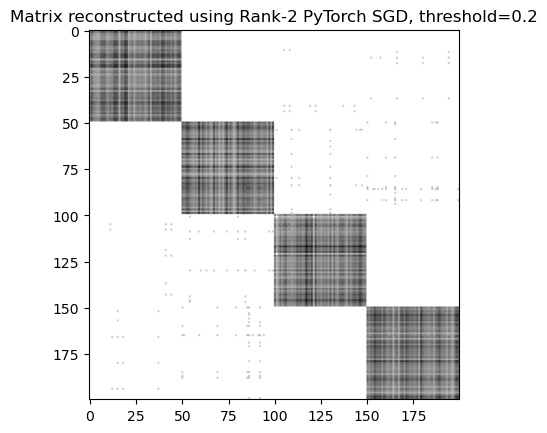

In [52]:
with torch.no_grad():
    sgd2_reconstructed = torch.sigmoid(sgd2.b + torch.matmul(sgd2.embs, torch.t(sgd2.embs)))
plotMatrices["rank-2 PyTorch SGD, threshold=0.2"] = torch.where(sgd2_reconstructed >= 0.2, sgd2_reconstructed, 0)
#sns.displot(sgd2_reconstructed.view(n*n))
plotReconstructed(sgd2_reconstructed, 0.2, "Rank-2 PyTorch SGD, threshold=0.2")


This looks really good as well. 

Ok, let's evaluate on the held-out set.

In [53]:
def predFnSGD3(x: torch.Tensor):
    return torch.sigmoid(sgd3.forward(x))

with torch.no_grad():
    r = evaluate(predFnSGD3, testSplit, threshold=0.2)
resultsDict["rank-3 PyTorch SGD"] = r
r

{'Mean. Squared Error': 0.10556985437870026,
 'Accuracy': 0.8321608304977417,
 'Precision': 0.5202952027320862,
 'Recall': 0.8057143092155457,
 'AUROC': 0.8044459930313589,
 'CrossEntropy': 0.7640621297606107}

In [54]:
def predFnSGD2(x: torch.Tensor):
    return torch.sigmoid(sgd2.forward(x))

with torch.no_grad():
    r = evaluate(predFnSGD2, testSplit, threshold=0.2)
resultsDict["rank-2 PyTorch SGD"] = r
r

{'Mean. Squared Error': 0.10683386772871017,
 'Accuracy': 0.8281406760215759,
 'Precision': 0.5202952027320862,
 'Recall': 0.8057143092155457,
 'AUROC': 0.8112334494773519,
 'CrossEntropy': 0.7800505547462152}

## 2.5 Putting It All Together

In [55]:
plotMatrices.keys()

dict_keys(['input', 'Original SBM embeddings', 'rank-4 SVD, threshold=0.2', 'rank-3 SVD, threshold=0.05', 'rank-2 SVD, threshold=0.01', 'rank-4 NMF, threshold=0.15', 'rank-5 NMF, threshold=0.15', 'rank-4 PyTorch SGD, threshold=0.2', 'rank-3 PyTorch SGD, threshold=0.2', 'rank-2 PyTorch SGD, threshold=0.2'])

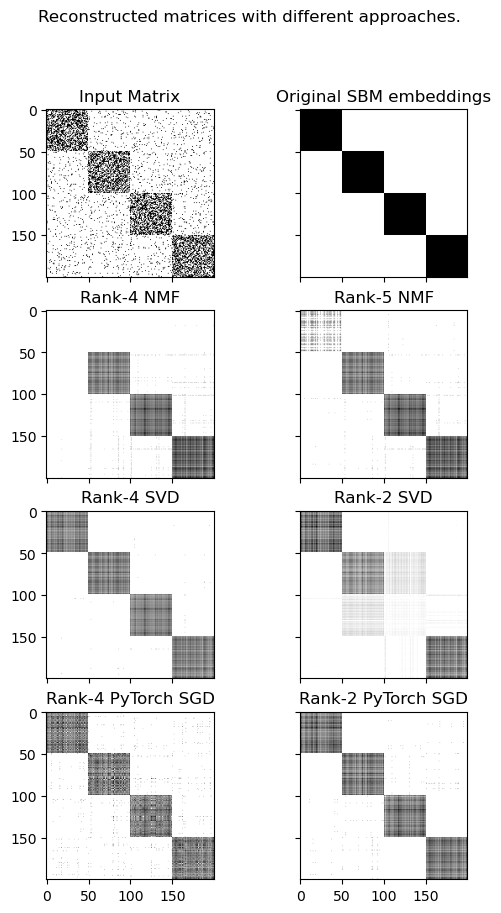

In [64]:
fig, axs = plt.subplots(4, 2)
fig.set_figheight(10)
fig.set_figwidth(6)
rec = "Reconstructed with "
axs[0, 0].imshow(plotMatrices["input"], cmap="binary")
axs[0, 0].set_title("Input Matrix")
axs[0, 1].imshow(plotMatrices["Original SBM embeddings"], cmap="binary")
axs[0, 1].set_title("Original SBM embeddings")
axs[1, 0].imshow(plotMatrices["rank-4 NMF, threshold=0.15"], cmap="binary")
axs[1, 0].set_title("Rank-4 NMF")
axs[1, 1].imshow(plotMatrices["rank-5 NMF, threshold=0.15"], cmap="binary")
axs[1, 1].set_title("Rank-5 NMF")
axs[2, 0].imshow(plotMatrices["rank-4 SVD, threshold=0.2"], cmap="binary")
axs[2, 0].set_title("Rank-4 SVD")
axs[2, 1].imshow(plotMatrices["rank-2 SVD, threshold=0.01"], cmap="binary")
axs[2, 1].set_title("Rank-2 SVD")
axs[3, 0].imshow(plotMatrices["rank-4 PyTorch SGD, threshold=0.2"], cmap="binary")
axs[3, 0].set_title("Rank-4 PyTorch SGD")
axs[3, 1].imshow(plotMatrices["rank-2 PyTorch SGD, threshold=0.2"], cmap="binary")
axs[3, 1].set_title("Rank-2 PyTorch SGD")
fig.suptitle("Reconstructed matrices with different approaches.")
# Rank-3 SVD is omitted as it's very similar to Rank-4 SVD. Similarly, Rank-3 PyTorch SGD is also omitted.
for ax in axs.flat:
    ax.label_outer()


Rank-4 SVD looks the cleanest of all and NMF looks the worst of all. It looks like for PyTorch SGD, Rank-2 is actually better than Rank-4. Possibly this is due to more overfitting. I omitted Rank-3 results for SGD and SVD for brevity. 



Let's check the quantitative results now. Before we do that, let's also get the numbers for "BSM embeddings", just for comparison. 

In [65]:
t = torch.tensor(sbmEmbs.todense())
def predFn(x: torch.Tensor):
    og = torch.sum(torch.mul(t[x[:, 0]], t[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))
resultsDict["rank-4 SBM"] = evaluate(predFn, testSplit, threshold = 0.1)

In [66]:
pd.DataFrame.from_dict(resultsDict).transpose().round(3)

Mean. Squared Error  Accuracy  Precision  Recall  AUROC  \
rank-4 SVD                        0.105     0.825      0.534   0.806  0.806   
rank-3 SVD                        0.116     0.823      0.534   0.806  0.828   
rank-2 SVD                        0.137     0.824      0.503   0.549  0.782   
rank-4 NMF                        0.124     0.826      0.518   0.577  0.712   
rank-5 NMF                        0.118     0.823      0.521   0.629  0.759   
rank-4 PyTorch SGD                0.108     0.833      0.505   0.800  0.801   
rank-3 PyTorch SGD                0.106     0.832      0.520   0.806  0.804   
rank-2 PyTorch SGD                0.107     0.828      0.520   0.806  0.811   
rank-4 BSM                        0.100     0.843      0.536   0.806  0.828   

                    CrossEntropy  
rank-4 SVD                 2.823  
rank-3 SVD                 7.817  
rank-2 SVD                 7.727  
rank-4 NMF                 0.978  
rank-5 NMF                 1.140  
rank-4 PyTorch SGD         0.802  
rank-3 PyTorch SGD         0.764  
rank-2 PyTorch SGD         0.780  
rank-4 BSM                 7.741

### 2.5.1 Takeaways

Here are a few takeaways. 
1. The Precision & Recall results for "rank-4 SBM" above represent the best possible result, in a sense. SVD and PyTorch SGD are able to get very close to this best possible result. 
2. NMF, even with rank-5, performs worse than SGD and SVD with rank-2. 
3. PyTorch SGD performs the best in terms of CrossEntropy, which makes sense, since that's what it it is explicitly optimized for. 
4. The results of rank-2 PyTorch SGD are arguably better than that of rank-4, suggesting that rank-4 may be overfitting. This is consistent with the matrix visualizations above as well. 

# 3 Overlapping SBMs
Let us now run the methods on SBM where each node can belong to 2 clusters (a primary and a secondary cluster). Let us also increase the noise in the generated graph to make the task more challenging. 

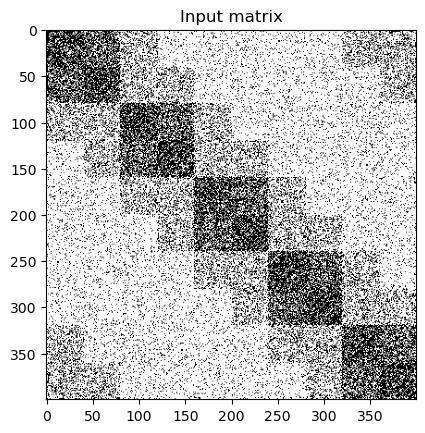

In [91]:
n = 400
numClusters = 5

sbm = SBM(n, numClusters)
(full, sbmEmbs) = sbm.generateOverlappingSBM(0.6, 0.3, 0.1)
plt.imshow(full, cmap="binary")
plt.title("Input matrix")
plt.show()
plotMatrices = {}
plotMatrices["input"] = full


In [92]:
fullTensor = torch.tensor([(i, j, full[i, j]) for i in range(n) for j in range(i+1, n)])
fullX = fullTensor[:, 0:2]
fullY = fullTensor[:, 2]
fullData = TensorDataset(fullX, fullY)
trainSplit, testSplit = torch.utils.data.random_split(fullData, [0.95, 0.05])

trainColsHalf = np.array([[x[0][0].item(), x[0][1].item(), y.item()] for x, y in DataLoader(trainSplit)])
trainColsOtherHalf = np.column_stack((trainColsHalf[:, 1], trainColsHalf[:, 0], trainColsHalf[:, 2]))
trainCols = np.concatenate((trainColsHalf, trainColsOtherHalf))
spTrain = sparse.coo_matrix((trainCols[:, 2], (trainCols[:, 0], trainCols[:, 1]))).astype(float)

In [117]:
t = torch.tensor(sbmEmbs.todense())
bsmReconstructed = t @ t.transpose(1, 0)

plotMatrices["Original SBM embeddings"] = bsmReconstructed
def predFn(x: torch.Tensor):
    og = torch.sum(torch.mul(t[x[:, 0]], t[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

resultsDict = {}
resultsDict["Rank-5 SBM"] = evaluate(predFn, testSplit, 0.01)


## 3.1 SVD

In [118]:
uOrig, s, vOrig = sparse.linalg.svds(spTrain, 6)
u6 = torch.tensor(uOrig @ np.sqrt(sparse.diags(s)))
v6 = torch.tensor(np.sqrt(sparse.diags(s)) @ vOrig)
assert torch.norm(u6 - v6.transpose(1, 0), 1) < 1e-5

u5 = u6[:, 1:6]
u2 = u6[:, 4:6]

svd5_reconstructed = u5 @ u5.transpose(1, 0)
plotMatrices["Rank-5 SVD"] = torch.where(svd5_reconstructed > 0.2, svd5_reconstructed, 0)
svd2_reconstructed = u2 @ u2.transpose(1, 0)
plotMatrices["Rank-2 SVD"] = torch.where(svd3_reconstructed > 0.2, svd3_reconstructed, 0)

def predFnSVD5(x: torch.Tensor):
    og = torch.sum(torch.mul(u5[x[:, 0]], u5[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

def predFnSVD2(x: torch.Tensor):
    og = torch.sum(torch.mul(u2[x[:, 0]], u2[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

resultsDict["Rank-5 SVD"] = evaluate(predFnSVD5, testSplit, 0.2)
resultsDict["Rank-2 SVD"] = evaluate(predFnSVD2, testSplit, 0.2)


## 3.2 NMF

In [119]:
_nmf6 = NMF(n_components=6, max_iter=1000)
nmf6 = _nmf6.fit_transform(spTrain)
nmf6 = torch.tensor(nmf6)

_nmf5 = NMF(n_components=5, max_iter=1000)
nmf5 = _nmf5.fit_transform(spTrain)
nmf5 = torch.tensor(nmf5)

nmf6_reconstructed = nmf6 @ nmf6.transpose(1, 0)
plotMatrices["Rank-6 NMF"] = torch.where(nmf6_reconstructed > 0.2, nmf6_reconstructed, 0)
nmf5_reconstructed = nmf5 @ nmf5.transpose(1, 0)
plotMatrices["Rank-5 NMF"] = torch.where(nmf5_reconstructed > 0.2, nmf5_reconstructed, 0)

def predFnNMF6(x: torch.Tensor):
    og = torch.sum(torch.mul(nmf6[x[:, 0]], nmf6[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

def predFnNMF5(x: torch.Tensor):
    og = torch.sum(torch.mul(nmf5[x[:, 0]], nmf5[x[:, 1]]), dim=1)
    return torch.where(og < 0, 0, torch.where(og > 1, 1, og))

resultsDict["Rank-6 NMF"] = evaluate(predFnNMF6, testSplit, 0.2)
resultsDict["Rank-5 NMF"] = evaluate(predFnNMF5, testSplit, 0.2)


## 3.3 PyTorch SGD

In [123]:
sgd5, _, _, _ = train(trainSplit, n, 5, nepochs=1000, posClassWeight=1)
sgd2, _, _, _ = train(trainSplit, n, 3, nepochs=1000, posClassWeight=1)

with torch.no_grad():
    sgd5_reconstructed = torch.sigmoid(sgd5.b + sgd5.embs @ sgd5.embs.T)
    sgd2_reconstructed = torch.sigmoid(sgd2.b + sgd2.embs @ sgd2.embs.T)

plotMatrices["Rank-5 PyTorch SGD"] = torch.where(sgd5_reconstructed > 0.2, sgd5_reconstructed, 0)
plotMatrices["Rank-2 PyTorch SGD"] = torch.where(sgd3_reconstructed > 0.2, sgd3_reconstructed, 0)

def predFnSGD5(x: torch.Tensor):
    return torch.sigmoid(sgd5.forward(x))

def predFnSGD2(x: torch.Tensor):
    return torch.sigmoid(sgd3.forward(x))

resultsDict["Rank-5 PyTorch SGD"] = evaluate(predFnSGD5, testSplit, 0.2)
resultsDict["Rank-2 PyTorch SGD"] = evaluate(predFnSGD2, testSplit, 0.2)

Avg L1 norm at init time:3.8427438354492187
Training epoch ..0....20....40....60....80....100....120..
Ending because loss is asymptoting (rollingAvg1: 0.004632673691958189, rollingAvg2: 0.004632451571524143)

Avg L1 norm at init time:2.2590187072753904
Training epoch ..0....20....40....60....80..
Ending because loss is asymptoting (rollingAvg1: 0.00477095041424036, rollingAvg2: 0.004770959261804819)



## 3.4 Putting it all together

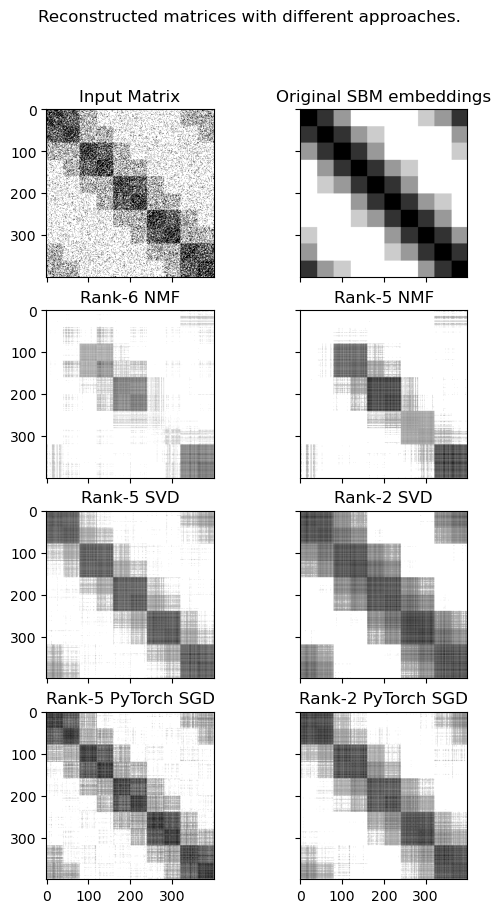

In [124]:
fig, axs = plt.subplots(4, 2)
fig.set_figheight(10)
fig.set_figwidth(6)
axs[0, 0].imshow(plotMatrices["input"], cmap="binary")
axs[0, 0].set_title("Input Matrix")
axs[0, 1].imshow(plotMatrices["Original SBM embeddings"], cmap="binary")
axs[0, 1].set_title("Original SBM embeddings")
axs[1, 0].imshow(plotMatrices["Rank-6 NMF"], cmap="binary")
axs[1, 0].set_title("Rank-6 NMF")
axs[1, 1].imshow(plotMatrices["Rank-5 NMF"], cmap="binary")
axs[1, 1].set_title("Rank-5 NMF")
axs[2, 0].imshow(plotMatrices["Rank-5 SVD"], cmap="binary")
axs[2, 0].set_title("Rank-5 SVD")
axs[2, 1].imshow(plotMatrices["Rank-2 SVD"], cmap="binary")
axs[2, 1].set_title("Rank-2 SVD")
axs[3, 0].imshow(plotMatrices["Rank-5 PyTorch SGD"], cmap="binary")
axs[3, 0].set_title("Rank-5 PyTorch SGD")
axs[3, 1].imshow(plotMatrices["Rank-2 PyTorch SGD"], cmap="binary")
axs[3, 1].set_title("Rank-2 PyTorch SGD")
fig.suptitle("Reconstructed matrices with different approaches.")

for ax in axs.flat:
    ax.label_outer()


In [125]:
pd.DataFrame.from_dict(resultsDict).transpose().round(3)

Mean. Squared Error  Accuracy  Precision  Recall  AUROC  \
Rank-5 SBM                        0.229     0.685      0.406   0.863  0.767   
Rank-5 SVD                        0.156     0.797      0.469   0.764  0.777   
Rank-2 SVD                        0.184     0.728      0.354   0.853  0.695   
Rank-6 NMF                        0.191     0.743      0.521   0.434  0.708   
Rank-5 NMF                        0.184     0.753      0.554   0.523  0.715   
Rank-5 PyTorch SGD                0.156     0.789      0.458   0.796  0.783   
Rank-2 PyTorch SGD                0.156     0.792      0.442   0.825  0.780   

                    CrossEntropy  
Rank-5 SBM                28.710  
Rank-5 SVD                 0.988  
Rank-2 SVD                 1.091  
Rank-6 NMF                 1.025  
Rank-5 NMF                 0.988  
Rank-5 PyTorch SGD         0.818  
Rank-2 PyTorch SGD         0.820

## 3.4.1 Takeaways

1. Both from the matrix visualizations as well as from the above results, PyTorch SGD seems to perform the best, followed closely by SVD. NMF really struggles on this dataset; Rank-6 NMF is easily outperformed by both Rank-2 SGD and Rank-2 SVD. 
2. While there's a noticeable decrease in quality from Rank-5 to Rank-2 SVD, there's a much smaller decrease for PyTorch SGD. This kind of graceful degradation could be important for real applications, where we typically are constrained on the rank of the embedding.  